# Periodic boundary conditions II (dynamics)

## Overview

In this session, we will learn how to compute dynamical quantities from an MD simulation. 

### Questions

- How do I compute dynamic quantities like the diffusion coefficient from a MD simulation?

### Objectives

- Calculate the mean-squared displacement of monomers, monomers relative to the center of mass of a polymer, and the center of mass MSD of a polymer.
- Extract the average diffusion coefficent from the measured MSD for a simple polymer model.
- Show that the simple polymer model agrees with scaling expectations (Rouse model).

## Boilerplate code

In [1]:
import matplotlib
import numpy  
import scipy.stats
import gsd, gsd.hoomd 
import freud 
import math
import itertools 
import hoomd 
import fresnel 

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

def render(frame):
    scene = fresnel.Scene()
    geometry = fresnel.geometry.Sphere(scene, N=frame.particles.N)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5)
    geometry.position[:] = frame.particles.position
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, frame.configuration.box,box_radius=0.01)
    L = frame.configuration.box[0]
    scene.camera = fresnel.camera.Perspective(position=(L*1.8, L*1.8, L * 2.2), look_at=(0, 0, 0), up=(0, 1, 0), height=0.28)

    if frame.bonds.N>0:
        geometry.radius[:] = [0.2]*frame.particles.N 

        all_bonds = numpy.stack(
        [
            frame.particles.position[frame.bonds.group[:, 0]],
            frame.particles.position[frame.bonds.group[:, 1]],
        ],
        axis=1,
        )
        # Use a distance cutoff (L/2) to filter bonds that span the periodic boundary
        bond_distances = numpy.linalg.norm(all_bonds[:,0,:]-all_bonds[:,1,:], axis=1)
        L = frame.configuration.box[0]
        bond_indices = numpy.where(bond_distances < L/2)[0]
        filtered_bonds = all_bonds[bond_indices, :, :]
        
        bonds = fresnel.geometry.Cylinder(scene, N=len(filtered_bonds))
        bonds.material = fresnel.material.Material(roughness=0.5)
        bonds.outline_width = 0.05

        bonds.points[:] = filtered_bonds
        bonds.radius[:] = [0.1]*len(filtered_bonds)
        bonds.material.primitive_color_mix = 1.0
        bonds.color[:] = fresnel.color.linear([0.8, 0.8, 0.8])
                
    return fresnel.preview(scene)

## Background

We will largely follow [Mussawisade, K., M. Ripoll, R. G. Winkler, and G. Gompper. "Dynamics of polymers in a particle-based mesoscopic solvent." The Journal of chemical physics 123, no. 14 (2005)](http://doi.org/10.1063/1.2041527) for our model/parameter choices. In this section, we will implement and run a Gaussian Chain simulation with no pair interactions. This will model a so-called "ideal polymer".

## Simulation 

### Initial snapshot 

Write a function that initializes `num_pol` with length `num_mon` each. Initialize them as straight rods inside the box. Feel free to ajust the box size to be large enough to fit the polymers.

In [2]:
def initialize_snapshot(num_pol,num_mon):
    
    position_x = numpy.linspace(-num_mon/2,num_mon/2-1,num_mon)
    position = numpy.hstack((position_x.reshape(num_mon,1),numpy.zeros(shape=(num_mon,2))))
    positions = []
    for i in range(num_pol):
        positions.append(position + [0,-num_mon/2+i*1.1,0])
    
    positions = numpy.asarray(positions).reshape(-1,3)
    
    bonds = numpy.vstack((numpy.arange(num_pol*num_mon-1),numpy.arange(1,num_pol*num_mon))).T
    bonds = bonds[bonds[:,1] % num_mon !=0 ]
    
    frame = gsd.hoomd.Frame()
    frame.particles.types = ['A']
    frame.particles.N = num_mon*num_pol
    frame.particles.position = positions
    frame.bonds.N = len(bonds)
    frame.bonds.group = bonds
    frame.bonds.types = ['b']
    L = 2*numpy.max(numpy.abs(position))
    frame.configuration.box = [L, L, L, 0, 0, 0]

    return frame 


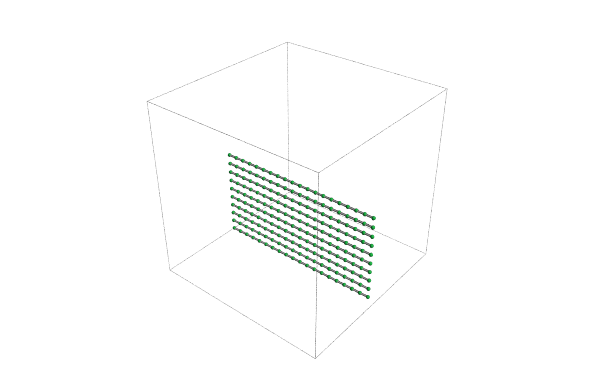

In [3]:
test = initialize_snapshot(10,20)
render(test)

This is one simple way to set up a initial configuration. For any actual workflow, it might be worthwile to improve this initial snapshot setup to get closer to a correct configuration, i.e for example one could implement a random walk or a self avoiding random walk. 

## Simulation setup 

The `num_mon` monomers in a Guassian chain are connected to form a polymer of length `mum_mon` by a *harmonic* bond potential. The spring constant is $\frac{3 k_{B} T}{2 b^{2}}$ and  with zero mean bond length. Here, $b$ is the root-mean-square bond length and $k_BT$ is the temperature. We rename the the root-mean-square bond length variable to $b$ (from $l$ used in the original paper) to avoid conflict with variable names used later.
*Note* that the factor of $1/2$ is already in hoomd-blue's definition of the [harmonic bond potential](https://hoomd-blue.readthedocs.io/en/stable/hoomd/md/bond/harmonic.html). 

Since the chains are non-interacting, i.e., they have no excluded volume, we might as well put some number of polymers, `num_pol`, into the simulation box to improve the statistics of the measurnments done later. If the chains were interacting, we would need to think about the effects of polymer concentrations. 

In [4]:
kT = 1.0
l = 1.0
harmonic = hoomd.md.bond.Harmonic()
harmonic.params["b"] = dict(r0=0, k=3*kT/l**2)

Now we can set up the rest of the simulation exactly like we have done for the Langevin simulations:

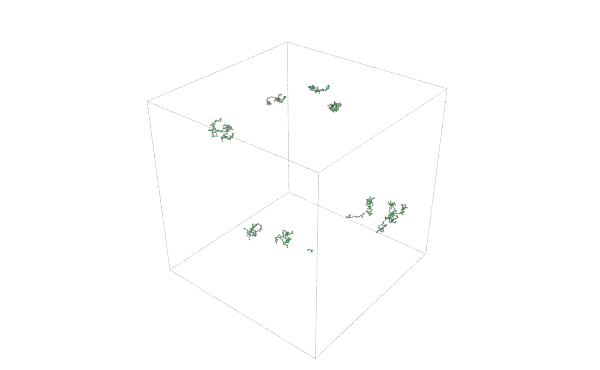

In [5]:
timestep = 0.01
gamma = 0.1

num_pol = 10
num_mon = 80

frame = initialize_snapshot(num_pol,num_mon)

integrator = hoomd.md.Integrator(dt=timestep)

integrator.forces.append(harmonic)

simulation = hoomd.Simulation(device=hoomd.device.auto_select(),seed=12)
simulation.operations.integrator = integrator 
simulation.create_state_from_snapshot(frame)

langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=kT,default_gamma=gamma)
integrator.methods.append(langevin)
simulation.operations.integrator = integrator 

simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)
# Equilibrate 
simulation.run(100_000)

gsd_out = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(1_000), 
    mode='wb',
    dynamic=['property','momentum'],
    filename='run_len_%s_pol_%s.gsd'%(num_mon,num_pol))

simulation.operations.writers.append(gsd_out)
# run
simulation.run(5_000_000)

gsd_out.flush()
render(simulation.state.get_snapshot())

While the simulation is running, look up what the scaling relationship for the [diffusion coefficent](https://en.wikipedia.org/wiki/Rouse_model) is expected to be for a simple polymer model without excluded volume interactions or hydrodynamics. Look up the **Rouse** and the **Zimm** model. 

To check if our simulation has run properly, we can check the bond lengths. The bond length distribution should follow a Gaussian distribution (as the name of the model implies): 

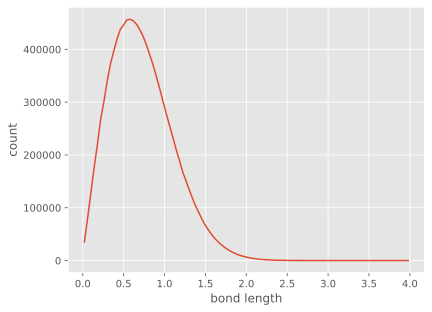

In [6]:
trajectory =  gsd.hoomd.open('run_len_80_pol_10.gsd','r')

all_bonds = []
for frame in trajectory: 
    unwrapped_positions = frame.particles.position + frame.particles.image*frame.configuration.box[0:3]
    bonds_lengths =  numpy.linalg.norm(unwrapped_positions[frame.bonds.group[:, 0]]- unwrapped_positions[frame.bonds.group[:, 1]],axis=1)
    all_bonds.append(bonds_lengths)

all_bonds = numpy.asarray(all_bonds).flatten() 
fig,ax = matplotlib.pyplot.subplots(1,1)

hist , edges = numpy.histogram(all_bonds, bins=100, range=(0,4))

center =  (edges[1:] + edges[:-1])/2
hist = hist/(4*numpy.pi*center*(center[1]-center[0]))
ax.plot(center,hist)
ax.set_xlabel("bond length") 
ax.set_ylabel("count")
matplotlib.pyplot.show()

## Analyze MSD 

To analyze the MSD, we will write a function that takes a filename for gsd trajectory, opens the trajectory and computes the MSD using [freud](https://freud.readthedocs.io/en/latest/modules/msd.html). We will compute the monomer MSD ($g_1$), the relative monomer to center of mass MSD ($g_2$), and the center of mass MSD ($g_3$). We expect both the monomer and the com MSD to eventually scale linearly with time, $MSD \sim t^1$. The relative monomer to center of mass diffusion will plateau out at long times. 

**Write a function that calculates all three MSDs.**

You will need to iterate over the trajectory, find a way to separate the positions for the different polymers (see last lecture!), calculate the center of mass of each polymer, and then save the unwrapped positions, center of mass, and the unwrapped positions relative (minus) the center of masses in arrays of appropriate shape. 

Note that we want to substract a *global* center of mass drift, i.e entire simulation drift. This drift should be minimal if the thermostat is working correctly. Especially for systems with only a few particles, there still can be some effect, simply because there are not enough velocities to ensure that the mean of all velocities is exactly zero. In any case, it does not hurt to substract the global center of mass from the positions once they are unwrapped. 

Once you have three arrays, one with unwrapped positions `all_unwrapped_positions`, one with relative unwraped positions `all_unwrapped_coms_particles`, and one with center of masses `all_unwrapped_coms`, we can use freud to compute the MSD in the next step. 

In [7]:
def analyze_msd(filename,timestep):
    trajectory =  gsd.hoomd.open(filename,'r')
    
    all_unwrapped_positions = []
    all_unwrapped_coms = []
    all_unwrapped_coms_particles = []
    times = []
    
    box  = trajectory[0].configuration.box[0:3]
    bonds =trajectory[0].bonds.group
    polymer_delimiters = bonds[numpy.where((bonds[:-1,1]-bonds[1:,0])!=0)[0]+1][:,0]
    time0 = trajectory[0].configuration.step 
    for frame in trajectory:
    
        unwrapped_positions = frame.particles.position + frame.particles.image*frame.configuration.box[0:3]
    
        unwrapped_positions = unwrapped_positions - numpy.mean(unwrapped_positions,axis=0)
        all_unwrapped_positions.append(unwrapped_positions)
        polymers = numpy.split(unwrapped_positions,polymer_delimiters)
        unwrapped_coms = []
    
        for p in polymers:
            com = numpy.mean(p,axis=0)
            unwrapped_coms.append(com)
    
        unwrapped_coms_tiled = numpy.repeat(unwrapped_coms,len(p),axis=0)
        all_unwrapped_coms_particles.append(unwrapped_positions-unwrapped_coms_tiled)
    
        all_unwrapped_coms.append(unwrapped_coms)
        times.append(frame.configuration.step-time0)
    
    all_unwrapped_positions = numpy.array(all_unwrapped_positions)  # shape = (nframes,nparticles,3)
    all_unwrapped_coms = numpy.array(all_unwrapped_coms)            # shape = (nframes,npolymers,3)
    all_unwrapped_coms_particles = numpy.array(all_unwrapped_coms_particles)  # shape = (nframes,nparticles,3)
    
    msd_calculator = freud.msd.MSD()
    msd_calculator.compute(all_unwrapped_positions)
    result = msd_calculator.particle_msd
    msd1 = numpy.nanmean(result,axis=1)
    
    msd_calculator.compute(all_unwrapped_coms_particles)
    result = msd_calculator.particle_msd
    msd2 = numpy.nanmean(result,axis=1)
    
    msd_calculator.compute(all_unwrapped_coms)
    result = msd_calculator.particle_msd
    msd3 = numpy.nanmean(result,axis=1)
    
    lagtimes = numpy.asarray(times)*timestep

    return lagtimes, msd1, msd2, msd3 

Now we can plot our results for one chain length, let's say $N=80$ and check against our expectations: 

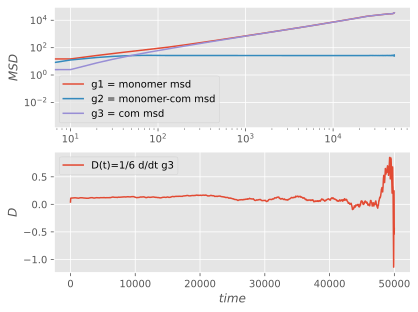

In [8]:
fig,ax = matplotlib.pyplot.subplots(2,1)

lagtimes, msd1, msd2, msd3 = analyze_msd("run_len_80_pol_10.gsd",0.01)
ax[0].plot(lagtimes, msd1,label='g1 = monomer msd')
ax[0].plot(lagtimes, msd2,label='g2 = monomer-com msd')
ax[0].plot(lagtimes, msd3,label='g3 = com msd')

gradient = numpy.gradient(msd3, lagtimes)
ax[1].plot(lagtimes,gradient/(6.0),label='D(t)=1/6 d/dt g3')


ax[0].set_ylabel("$MSD$")
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[1].legend()

ax[1].set_xlabel(r"$time$")
ax[1].set_ylabel("$D$")

matplotlib.pyplot.show()

Now, repeat the above simulation for a few values of $N$ in the range of 20 to 80:

In [9]:
num_pol = 10

for num_mon in [20,40]:
    frame = initialize_snapshot(num_pol,num_mon)
    
    integrator = hoomd.md.Integrator(dt=timestep)
    
    harmonic = hoomd.md.bond.Harmonic()
    harmonic.params["b"] = dict(r0=0, k=3*kT/l**2)
    integrator.forces.append(harmonic)
    
    simulation = hoomd.Simulation(device=hoomd.device.auto_select(),seed=45)
    simulation.operations.integrator = integrator 
    simulation.create_state_from_snapshot(frame)
    
    langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=kT,default_gamma=gamma)
    integrator.methods.append(langevin)
    simulation.operations.integrator = integrator 
    
    simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)
    # Equilibrate 
    simulation.run(100_000)
    
    gsd_out = hoomd.write.GSD(
        trigger=hoomd.trigger.Periodic(1_000), 
        mode='wb',
        dynamic=['property','momentum'],
        filename='run_len_%s_pol_%s.gsd'%(num_mon,num_pol))
    
    simulation.operations.writers.append(gsd_out)
    # run
    simulation.run(5_000_000)
    
    gsd_out.flush()

After that, let's determine the $MSD$, $D(t)$ and $\langle D\rangle$ of each chain length:

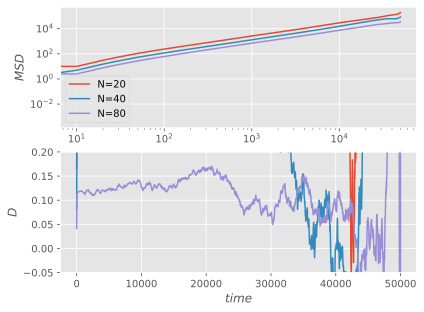

In [10]:
fig,ax = matplotlib.pyplot.subplots(2,1)

fit_range = [10,30000]

Ns = [20,40,80]
all_av_D = [] 

for N in Ns:
    lagtimes, msd1, msd2, msd3 = analyze_msd("run_len_%s_pol_10.gsd"%(N),0.01)
    D = numpy.gradient(msd3, lagtimes)/6.0
    ax[0].plot(lagtimes, msd3,label='N=%s'%N)
    ax[1].plot(lagtimes,D)
    diffusion_coefficient = numpy.mean(D[(lagtimes>fit_range[0]) & (lagtimes<fit_range[1])])
    all_av_D.append(diffusion_coefficient)

ax[0].set_ylabel("$MSD$")
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[1].set_ylim(-0.05,0.2)
ax[1].set_xlabel(r"$time$")
ax[1].set_ylabel("$D$")
matplotlib.pyplot.show()

For comparison, load the file `gaussian-D-Rg.txt`, which contains calculated diffusion coefficents (and $R_g$ in column 3) for $N=10$ to $100$ and plot your data with those diffusion coefficients. Do they follow the expected scaling law? 

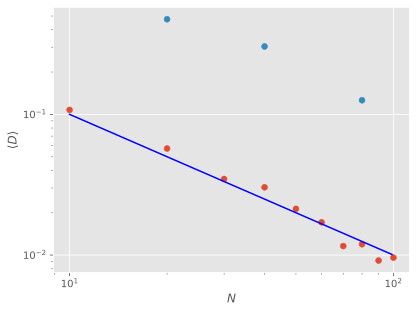

In [11]:
fig,ax = matplotlib.pyplot.subplots(1,1)
x = numpy.arange(10,100,1)
data = numpy.genfromtxt("gaussian-D-Rg.txt") 
ax.plot(x,1/(x),c='blue')
ax.scatter(data[:,0], data[:,1])
ax.scatter(Ns, all_av_D)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$\langle D \rangle$")
matplotlib.pyplot.show()


## Additions 

1. How would you decide on the `fit_range` for the diffusion coefficient? *Hint:* Is there a way to estimate the uncertainty of $D(t)$?
2. What happens if we add pair interactions to our simulation? What solvent qualities can we model? Do the results still agree with the Rouse model expectations?
3. What happens if we change the temperature `kT`$=k_{\mathrm {B}}T$ or the friction coefficient `gamma` in our simulations? Do the results still agree with the Rouse model expectations?